# SageMaker A/B Testing: A Practical Simulation

This notebook demonstrates how to implement and evaluate A/B testing strategies with Amazon SageMaker. A/B testing is a critical technique for data-driven decision making, allowing you to compare two variants of a machine learning model to determine which performs better in real-world scenarios.

Rather than deploying multiple model variants to production endpoints (which would incur significant AWS costs), this notebook uses simulation to illustrate the key concepts and analysis techniques of A/B testing. This simulation-based approach provides several advantages:

- **Cost-effective learning**: Explore A/B testing methodologies without incurring the expenses of running multiple SageMaker endpoints
- **Rapid experimentation**: Test different traffic allocation scenarios and analysis techniques instantly
- **Educational value**: Focus on understanding the metrics and decision-making process without debugging deployment issues

## Overview:
1. Set up simulated model variants with different performance characteristics
2. Distribute synthetic traffic between these variants
3. Collect and analyze conversion metrics over time
4. Visualize the results to identify the better-performing model
5. Make data-driven recommendations for full deployment

While simulation is used for this demonstration, the concepts, code patterns, and analysis techniques can be directly applied to real-world SageMaker deployments when you're ready to implement production A/B testing.

Let's begin by setting up our simulated A/B testing environment

In [6]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from datetime import datetime, timedelta

# Setup clients
sm = boto3.client('sagemaker')
sm_runtime = boto3.client('sagemaker-runtime')

# Define endpoint and variant configuration
endpoint_name = "xgb-churn-pred"
model_name = "xgb-churn-model"

# Define two variants for A/B testing
variant1 = {
    "VariantName": "ModelVariant1",  # Original model
    "ModelName": model_name,
    "InitialInstanceCount": 1,
    "InstanceType": "ml.m5.large",
    "InitialVariantWeight": 0.5  # 50% of traffic
}

variant2 = {
    "VariantName": "ModelVariant2",  # Improved model
    "ModelName": model_name,
    "InitialInstanceCount": 1,
    "InstanceType": "ml.m5.large",
    "InitialVariantWeight": 0.5  # 50% of traffic
}



In [7]:
# For this example, we'll skip actually creating the endpoint
print(f"Demonstrating A/B testing for endpoint: {endpoint_name}")
print(f"Variant 1: {variant1['VariantName']} (Weight: {variant1['InitialVariantWeight']})")
print(f"Variant 2: {variant2['VariantName']} (Weight: {variant2['InitialVariantWeight']})")

# Simulate A/B test traffic and results
def simulate_ab_test(num_requests=100, days=5):
    """Simulate A/B test results over a period of days"""
    np.random.seed(42)  # For reproducibility
    
    # Create date range
    today = datetime.now().date()
    date_range = [today - timedelta(days=(days-i)) for i in range(1, days+1)]
    
    # Initialize results DataFrames
    traffic_data = []
    conversion_data = []
    
    # Model performance characteristics (simulate variant2 being slightly better)
    variant1_conversion_rate = 0.15
    variant2_conversion_rate = 0.18
    
    for date in date_range:
        # Randomly distribute traffic based on weights
        daily_requests = num_requests + np.random.randint(-10, 10)  # Add some noise
        variant1_traffic = int(daily_requests * variant1['InitialVariantWeight'])
        variant2_traffic = daily_requests - variant1_traffic
        
        # Calculate conversions based on simulated rates
        variant1_conversions = int(variant1_traffic * variant1_conversion_rate * (1 + np.random.normal(0, 0.1)))
        variant2_conversions = int(variant2_traffic * variant2_conversion_rate * (1 + np.random.normal(0, 0.1)))
        
        # Record data
        traffic_data.append({
            'date': date,
            'variant1_traffic': variant1_traffic,
            'variant2_traffic': variant2_traffic
        })
        
        conversion_data.append({
            'date': date,
            'variant1_conversions': variant1_conversions,
            'variant2_conversions': variant2_conversions
        })
    
    return pd.DataFrame(traffic_data), pd.DataFrame(conversion_data)



Demonstrating A/B testing for endpoint: xgb-churn-pred
Variant 1: ModelVariant1 (Weight: 0.5)
Variant 2: ModelVariant2 (Weight: 0.5)


In [8]:
# Run simulation
traffic_df, conversion_df = simulate_ab_test(num_requests=200, days=7)

# Display results
print("\nSimulated traffic distribution:")
print(traffic_df)
print("\nSimulated conversion results:")
print(conversion_df)

# Calculate metrics
results = pd.merge(traffic_df, conversion_df, on='date')
results['variant1_rate'] = results['variant1_conversions'] / results['variant1_traffic']
results['variant2_rate'] = results['variant2_conversions'] / results['variant2_traffic']
results['improvement'] = ((results['variant2_rate'] - results['variant1_rate']) / 
                         results['variant1_rate'] * 100)




Simulated traffic distribution:
         date  variant1_traffic  variant2_traffic
0  2025-05-22                98                98
1  2025-05-23                98                99
2  2025-05-24               104               104
3  2025-05-25                96                97
4  2025-05-26                95                96
5  2025-05-27                95                96
6  2025-05-28               100               101

Simulated conversion results:
         date  variant1_conversions  variant2_conversions
0  2025-05-22                    13                    18
1  2025-05-23                    13                    18
2  2025-05-24                    15                    16
3  2025-05-25                    14                    15
4  2025-05-26                    14                    17
5  2025-05-27                    13                    16
6  2025-05-28                    15                    17


In [12]:
print("\nA/B Test Analysis:")
print(results[['date', 'variant1_rate', 'variant2_rate', 'improvement']])

# Calculate overall metrics
total_v1_traffic = results['variant1_traffic'].sum()
total_v2_traffic = results['variant2_traffic'].sum()
total_v1_conversions = results['variant1_conversions'].sum()
total_v2_conversions = results['variant2_conversions'].sum()
overall_v1_rate = total_v1_conversions / total_v1_traffic
overall_v2_rate = total_v2_conversions / total_v2_traffic
overall_improvement = ((overall_v2_rate - overall_v1_rate) / overall_v1_rate) * 100

print(f"\nOverall Results:")
print(f"Variant 1 Conversion Rate: {overall_v1_rate:.2%}")
print(f"Variant 2 Conversion Rate: {overall_v2_rate:.2%}")
print(f"Improvement (relative improvement of Variant 2 over Variant 1.): {overall_improvement:.2f}%")




A/B Test Analysis:
         date  variant1_rate  variant2_rate  improvement
0  2025-05-22       0.132653       0.183673    38.461538
1  2025-05-23       0.132653       0.181818    37.062937
2  2025-05-24       0.144231       0.153846     6.666667
3  2025-05-25       0.145833       0.154639     6.038292
4  2025-05-26       0.147368       0.177083    20.163690
5  2025-05-27       0.136842       0.166667    21.794872
6  2025-05-28       0.150000       0.168317    12.211221

Overall Results:
Variant 1 Conversion Rate: 14.14%
Variant 2 Conversion Rate: 16.93%
Improvement (relative improvement of Variant 2 over Variant 1.): 19.75%


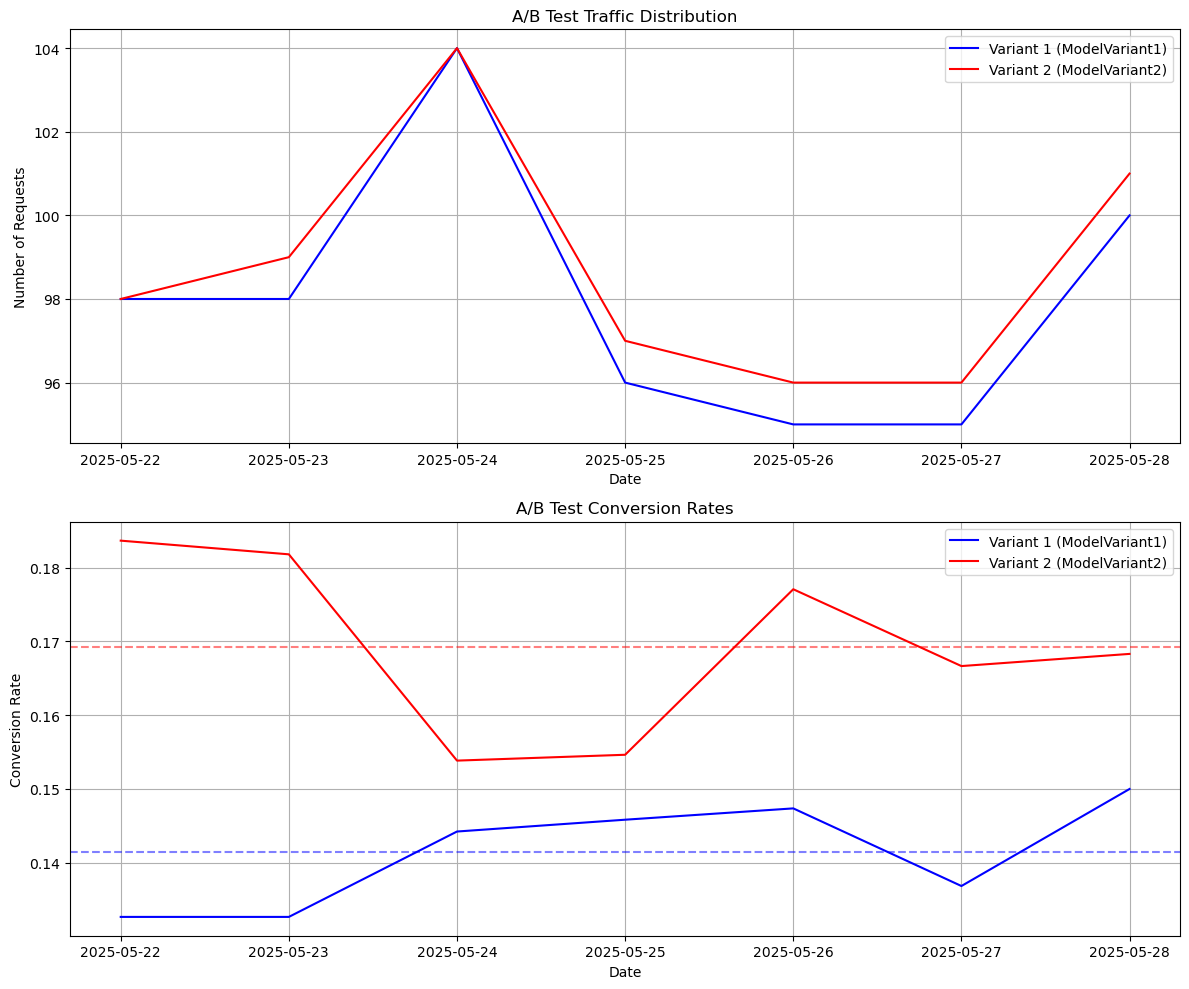

In [10]:
# Visualization
plt.figure(figsize=(12, 10))

# Plot 1: Traffic distribution
plt.subplot(2, 1, 1)
plt.title('A/B Test Traffic Distribution')
plt.plot(results['date'], results['variant1_traffic'], 'b-', label=f'Variant 1 ({variant1["VariantName"]})')
plt.plot(results['date'], results['variant2_traffic'], 'r-', label=f'Variant 2 ({variant2["VariantName"]})')
plt.xlabel('Date')
plt.ylabel('Number of Requests')
plt.legend()
plt.grid(True)

# Plot 2: Conversion rates
plt.subplot(2, 1, 2)
plt.title('A/B Test Conversion Rates')
plt.plot(results['date'], results['variant1_rate'], 'b-', label=f'Variant 1 ({variant1["VariantName"]})')
plt.plot(results['date'], results['variant2_rate'], 'r-', label=f'Variant 2 ({variant2["VariantName"]})')
plt.axhline(y=overall_v1_rate, color='b', linestyle='--', alpha=0.5)
plt.axhline(y=overall_v2_rate, color='r', linestyle='--', alpha=0.5)
plt.xlabel('Date')
plt.ylabel('Conversion Rate')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



In [11]:
# Recommendation based on A/B test results
if overall_improvement > 5:
    print("\nRecommendation: Deploy Variant 2 fully (100% traffic)")
elif overall_improvement > 0:
    print("\nRecommendation: Consider longer testing or deploy Variant 2")
else:
    print("\nRecommendation: Keep Variant 1 as the primary model")


Recommendation: Deploy Variant 2 fully (100% traffic)
